<center>Национальный исследовательский университет ИТМО<br/>Факультет информационных технологий и программирования<br/>Прикладная математика и информатика</center>

## <center>Математическая статистика</center>
### <center>Отчёт по лабораторной работе №3</center>

<div style="text-align: right"><b>Работу выполнили:</b><br/>Белоцерковченко Андрей M3337<br/>Смирнов Андрей M3337<br/</div>

<center>Санкт-Петербург<br/>2023</center>

In [3]:
import numpy as np
import scipy as sc
from math import sqrt
from scipy.stats import norm
from matplotlib import pyplot as plt


## Доверительный интервал уровня $1 - \alpha$
### Теория

Есть две выборки $X_1, X_2 \dots X_n \sim N(\mu_1, \sigma_1^2)$ и $Y_1, Y_2 \dots Y_m \sim N(\mu_2, \sigma_2^2)$. Оцениваем $\theta = \cfrac{\sigma_1^2}{\sigma_2^2}$, при этом $\mu_1$ и $\mu_2$ нам известны. 

Первым делом введём слуайную величину $U_1 = \sum\limits_{i = 1}^n(\cfrac{X_i - \mu_1}{\sigma_1})^2$. Т.к. выборка распределена по нормальному закону - мы можем сказать, что $U_1 \sim \chi^2(n)$. Аналогично для $Y_i$ вводим случайную величину $U_2$

По определению распределения Фишера получаем, что $$\cfrac{U_2 / m}{U_1 / n} \sim F(m, n)$$ расписываем отношение и получаем: 
$$\cfrac{n\sum\limits_{j = 1}^m(Y_j - \mu_2)^2}{m\sum\limits_{i = 1}^n(X_i - \mu_1)^2}\tau \sim F(m, n)$$

Теперь мы можем посчитать доверительный ряд: $$P(q_{\frac{\alpha}{2}} \leq \cfrac{n\sum\limits_{j = 1}^m(Y_j - \mu_2)^2}{m\sum\limits_{i = 1}^n(X_i - \mu_1)^2}\tau \leq q_{1 - \frac{\alpha}{2}}) = 1 - \alpha$$

Таким образом, доверительный интервал будет иметь следующий вид: 
$$\tau \in \Bigg[ q_{\frac{\alpha}{2}}\cfrac{m\sum\limits_{i = 1}^n(X_i - \mu_1)^2}{n\sum\limits_{j = 1}^m(Y_j - \mu_2)^2}; q_{1 - \frac{\alpha}{2}}\cfrac{m\sum\limits_{i = 1}^n(X_i - \mu_1)^2}{n\sum\limits_{j = 1}^m(Y_j - \mu_2)^2} \Bigg]$$

### Эксперименты
Напишем класс-генератор выборок:

In [68]:
class NormalDistributionSamples:
    def __init__(self, mu1, sigma1, sz1, mu2, sigma2, sz2, alpha):
        self.X = []
        self.Y = []
        self.l_int = None
        self.r_int = None
        self.total_count = 0
        self.not_covers_count = 0
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.sz1 = sz1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.sz2 = sz2
        self.alpha = alpha
        self.q1 = sc.stats.f.ppf(alpha / 2, sz2, sz1)
        self.q2 = sc.stats.f.ppf(1 - alpha / 2, sz2, sz1)
        self.tau = sigma1 / sigma2
    
    def generate_samples(self):
        self.total_count += 1
        self.X = sc.stats.norm.rvs(loc=self.mu1, scale=sqrt(self.sigma1), size=self.sz1)
        self.Y = sc.stats.norm.rvs(loc=self.mu2, scale=sqrt(self.sigma2), size=self.sz2)
        
    def count_interval(self):
        a = self.sz2 * sum(map(lambda x: (x - self.mu1) ** 2, self.X))
        b = self.sz1 * sum(map(lambda y: (y - self.mu2) ** 2, self.Y))
        fvalue = a / b
        self.l_int = self.q1 * fvalue
        self.r_int = self.q2 * fvalue
        
    def check_tau(self):
        if not (self.l_int < self.tau < self.r_int):
            self.not_covers_count += 1
            
    def show_error(self):
        print("After", self.total_count, "samples, the tau went outside")
        print("Total:", self.not_covers_count)
        print("%:", (self.not_covers_count / self.total_count) * 100)

Сначала попробуем посчитать интервал для размера выборок 25. Параметрами возьмём $\mu_1 = \mu_2 = 0, \sigma_1^2 = 2, \sigma_2^2 = 1$. Считаем 95% доверительный интервал

In [69]:
def perform_test(repeats, distr_sizes):
    tester = NormalDistributionSamples(0, 2, distr_sizes, 0, 1, distr_sizes, 0.05)
    for i in range(repeats):
        tester.generate_samples()
        tester.count_interval()
        tester.check_tau()
        
    tester.show_error()

In [72]:
perform_test(1000, 25)

After 1000 samples, the tau went outside
Total: 47
%: 4.7


In [71]:
perform_test(1000, 10000)

After 1000 samples, the tau went outside
Total: 58
%: 5.800000000000001


Таким образом, в обоих случаях процент ошибок составил приблизительно $5$ процентов и размер выборки на это не повлиял. Объяснить это можно тем, что мы буквально по определению находим интервал такой, что $P(\tau \in [T_1, T_2]) \geq 0.95$

# Медиана экспоненциального распределения

Во первых необходимо вычислить медиану которая получилась в теории, а именно раз уж медиана это такая точка в которой ровно половина значений меньше или равна медиане то ее можно вычислить по следующей формуле:
$$0.5 = \int_{-\infty}^{m} f(x) \, dx, f(x) = \lambda e^{-\lambda x}, \lambda = 1$$
$$0.5 = -e^{-m} \Rightarrow m = ln(2)$$

Далее воспользуемся нашей подсказкой, а именно. Теорема об асимптотическом поведении среднего члена вариационного ряда утверждает, что в пределе, при увеличении размера выборки, порядковая статистика (в том числе медиана) подчиняется нормальному распределению. Для экспоненциального распределения это означает, что порядковая статистика, соответствующая медиане, стремится к нормальному распределению с определенными параметрами.

Значит мы можем аппроксимировать нашу дисперсию нормальным распределением, что даст нам формулу для дисперсии: $\frac{1}{4n\lambda^2 f^2(\bar{x})}$ или $\sigma = \frac{1}{2\sqrt{n}\lambda f(\bar{x})}$ - стандартная ошибка нашей медианы. А уже отсюда мы можем найти наш доверительный интервал.

Что легко вычисляется и получается, что $\sigma = \frac{1}{\sqrt{n}}$ и доверительный интервал:
$$($m - z_{\alpha / 2} \sqrt{\frac{1}{n}}, m + z_{\alpha / 2} \sqrt{\frac{1}{n}}$)$$

In [4]:
np.random.seed(52)  # Задаём seed для воспроизводимости
sizes = [25, 10000]
iterations = 1000
lambda_val = 1
true_med = np.log(2)    # Можно вычислить
alpha = 0.05    # т.к. вычисляем 95 процентиль

In [5]:
# Генерация выборок и подсчёт интервалов для размеров 25 и 10000
def calculate_confidence_intervals(sample_size):
    hits = 0
    medians = []

    for _ in range(iterations):
        sample = np.random.exponential(scale=1, size=sample_size)
        median = np.median(sample)
        
        medians.append(median)
        
        # Асимптотический доверительный интервал
        sigma = 1 / np.sqrt(sample_size)
        
        lower = norm.ppf(alpha / 2, loc=median, scale=sigma)
        upper = norm.ppf(1 - alpha / 2, loc=median, scale=sigma)

        if lower <= true_med <= upper:
            hits += 1

    return hits, medians

hits = 946, iterations = 1000, probability = 0.946
hits = 955, iterations = 1000, probability = 0.955


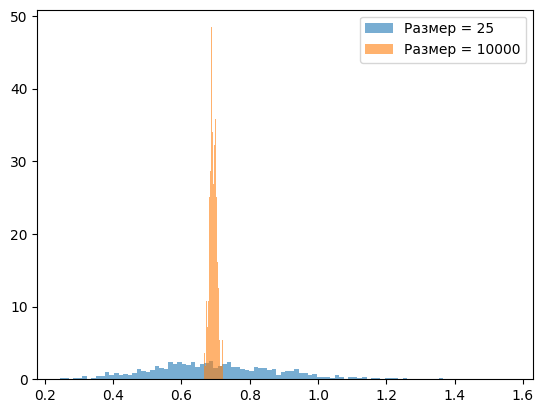

In [6]:
for size in sizes:
    hits, medians = calculate_confidence_intervals(size)
    probability = hits / iterations
    print(f"hits = {hits}, iterations = {iterations}, probability = {probability}")
    plt.hist(medians, bins=100, alpha=0.6, label=f'Размер = {size}', density=True)
    
plt.legend()
plt.show()